ALL Implementation are from this video and they will be little bit modified
https://youtube.com/playlist?list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&si=6l_kJAuCYCx6YTmp

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# **Pix -2 - Pix Paper implementation**

* It is basically a conditional GAN with normal discrimninator loss as loss function for generator rather than using WGAN loss which gives bad results in this case
* Here we use L1 loss added into discriminator as L2 loss produces blurry images
* Here they have UNET architecture for generator and for discriminator they have used normal encoder - decoder architecture
* Here they used PatchGAN which is discriminator architecture that scans whole  one image by one patch by patch predicting that patch is real or fake

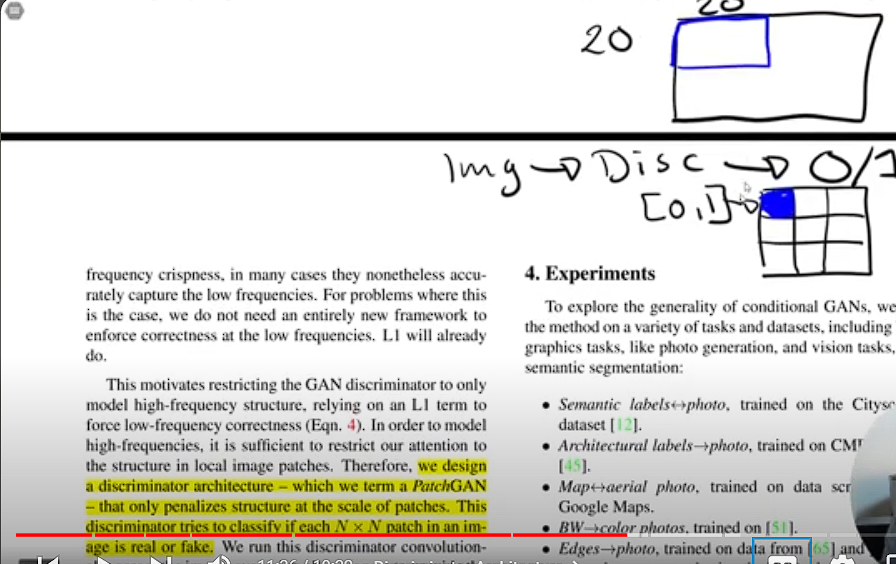

* Hyper Parameters are Adam Optimizer and Beta 1 =0.5 and beta2 = 0.999 learning rate was 0.0002
* Patch size: they tried 1X1, 16x16, 70x70, 286x286 (whole image)
of these patch size 70x70 showed slightly good results than 16x16
* Network Architecture :
  * They have used Ck which denotes Convolution-BatchNorm-ReLU with k filters.
  * They have used CDk which denotes convolution-BatchNorm-DropOut-ReLU with k filters with dropout rate of 50% here all convolution kernel size is of 4x4 with stride of 2
  * Here they encoder downsample the image by factor of 2 and upsample by factor of 2 in decoder
* Generator Architecture:
  * encoder:
  C64-C128-C256-C512-C512-C512-C512-C512
  * Decoder without skip connection:
  CD512-CD512-CD512-C512-C256-C128-C64
  * after last layer in the decoder a convolution is applied to map to the number of output channel (3 in general except in clorization, where it is 2) followed by Tanh function and BatchNormalization is not applied at C64 layer in encoder
  * All ReLU in the encoder are leaky with slope 0.2 while ReLU in the decoder are not leaky
  * U-Net Decoder with skip connections:CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
* Discriminator Architecture:
  * The 70x70 Patch Discriminator: C64-C128-C256-C512
    * After last layer Convolution is applied to map to 1 dimensional output followed by a sigmoid function and BatchNorm is not applied at first C64 layer
    * All ReLU are Leky with 0.2 slope
  * 1x1 Patch Discriminator : C64-C128 (with 1x1 kernel)
  * 16x16 Patch Discriminator : C64-C128
  * 286x286 Patch Discriminator : C64-C128-C256-C512-C512-C512

* Training:
  * Weights are intialized from Gaussian distribution with mean of 0 and standard deviation of 0.02

In [2]:
class CNNBlock(nn.Module):
  def __init__(self,in_channels,out_channels,stride=2):
    super(CNNBlock,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,4,stride,bias=False,padding_mode="reflect"),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
  def forward(self,x):
    return self.conv(x)

In [3]:
class pixDiscriminator(nn.Module):
  def __init__(self,in_channels=3,features=[64,128,256,512]):
    super(pixDiscriminator,self).__init__()
    self.intial = nn.Sequential(
        nn.Conv2d(in_channels*2,features[0],kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
        nn.LeakyReLU(0.2)
    )
    layers=[]
    in_channels =features[0]
    for feature in features[1:]:
      layers.append(
          CNNBlock(in_channels,feature,stride=1 if feature==features[-1] else 2)
      )
      in_channels = feature
    layers.append(
        nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode='reflect')
    )
    self.models = nn.Sequential(*layers)
  def forward(self,x,y):
    x = torch.cat([x,y],dim=1)
    x = self.intial(x)
    return self.models(x)


In [4]:
def test():
  x = torch.randn((1,3,256,256))
  y = torch.randn((1,3,256,256))
  model = pixDiscriminator()
  preds = model(x,y)
  print(preds.shape)
test()

torch.Size([1, 1, 26, 26])


In [5]:
class Block(nn.Module):
  def __init__(self,in_channels,out_channels,down=True,act='relu',dropout=False):
    super(Block,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,4,2,1,bias=False,padding_mode='reflect')
        if down
        else nn.ConvTranspose2d(in_channels,out_channels,4,2,1,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
    )
    self.use_droput = dropout
    self.dropout = nn.Dropout(0.5)

  def forward(self,x):
    x = self.conv(x)
    return self.dropout(x) if self.use_droput else x

In [6]:
class pixGenerator(nn.Module):
  def __init__(self,in_channels=3,features=64):
    super(pixGenerator,self).__init__()
    self.intial_down = nn.Sequential(
        nn.Conv2d(in_channels,features,4,2,1,padding_mode='reflect'),
        nn.LeakyReLU(0.2)

    )
    self.down1 = Block(features,features*2,down=True,act='leaky',dropout=False)
    self.down2 = Block(features*2,features*4,down=True,act='leaky',dropout=False)
    self.down3 = Block(features*4,features*8,down=True,act='leaky',dropout=False)
    self.down4 = Block(features*8,features*8,down=True,act='leaky',dropout=False)
    self.down5 = Block(features*8,features*8,down=True,act='leaky',dropout=False)
    self.down6 = Block(features*8,features*8,down=True,act='leaky',dropout=False)
    self.bottleneck = nn.Sequential(
        nn.Conv2d(features*8,features*8,4,2,1,padding_mode='reflect'),
        nn.ReLU()
    )
    self.up1 = Block(features*8,features*8,down=False,act='relu',dropout=True)
    self.up2 = Block(features*8*2,features*8,down=False,act='relu',dropout=True)
    self.up3 = Block(features*8*2,features*8,down=False,act='relu',dropout=True)
    self.up4 = Block(features*8*2,features*8,down=False,act='relu',dropout=False)
    self.up5 = Block(features*8*2,features*4,down=False,act='relu',dropout=False)
    self.up6 = Block(features*4*2,features*2,down=False,act='relu',dropout=False)
    self.up7 = Block(features*2*2,features,down=False,act='relu',dropout=False)
    self.final_up = nn.Sequential(
        nn.ConvTranspose2d(features*2,in_channels,kernel_size=4,stride=2,padding=1),
        nn.Tanh(),
    )
  def forward(self,x):
    d1 = self.intial_down(x)
    d2 = self.down1(d1)
    d3 = self.down2(d2)
    d4 = self.down3(d3)
    d5 = self.down4(d4)
    d6 = self.down5(d5)
    d7 = self.down6(d6)
    bottleneck = self.bottleneck(d7)
    up1 = self.up1(bottleneck)
    up2 = self.up2(torch.cat([up1,d7],dim=1))
    up3 = self.up3(torch.cat([up2,d6],dim=1))
    up4 = self.up4(torch.cat([up3,d5],dim=1))
    up5 = self.up5(torch.cat([up4,d4],dim=1))
    up6 = self.up6(torch.cat([up5,d3],dim=1))
    up7 = self.up7(torch.cat([up6,d2],dim=1))
    return self.final_up(torch.cat([up7,d1],dim=1))

def test():
  x = torch.randn((1,3,256,256))
  model = pixGenerator(in_channels=3,features=64)
  preds = model(x)
  print(preds.shape)
test()

torch.Size([1, 3, 256, 256])


In [63]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
EPOCH = 100
LAMBDA = 100
LEARNING_RATE = 2e-4
LOAD_MODEL = False
SAVE_MODEL = True
BATCH_SIZE = 16
CHECKPOINT_GEN = 'gen.pth.tar'
CHECKPOINT_DESC = 'disc.pth.tar'
NUM_WORKERS = 2
IMAGE_SIZE =256
IMAGE_CHANNELS =3



both_transform = A.Compose(
    [
        A.Resize(width=256,height=256),
        A.HorizontalFlip(p=0.5),
    ],
    additional_targets={'image0':'image'},
)

transforms_only_input = A.Compose(
    [
      A.ColorJitter(p=0.1),
      A.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5], max_pixel_value=255.0,),
      ToTensorV2(),
    ]
)

transforms_only_mask = A.Compose(
    [
      A.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5], max_pixel_value=255.0,),
      ToTensorV2(),
    ]
)

In [49]:
import os
import numpy as np
from PIL import Image
class MapDataset(Dataset):
  def __init__(self,root_dir):
    self.root_dir = root_dir
    self.list_files = os.listdir(self.root_dir)
    print(self.list_files)

  def __len__(self):
    return len(self.list_files)
  def __getitem__(self, index):
    img_file = self.list_files[index]
    img_path = os.path.join(self.root_dir,img_file)
    image = np.array(Image.open(img_path))
    input_img = image[:,512:,:]
    target_img = image[:,:512,:]
    # both_transform.is_check_shapes = False
    augmentations = both_transform(image=input_img,image0=target_img)
    input_img = augmentations['image']
    target_img = augmentations['image0']
    input_img = transforms_only_input(image=input_img)['image']
    target_img = transforms_only_input(image=target_img)['image']
    return input_img,target_img

In [64]:
from torchvision.utils import save_image

def save_some_examples(gen,val_loader,epoch,folder):
  x,y= next(iter(val_loader))
  x,y = x.to(DEVICE),y.to(DEVICE)
  gen.eval()
  with torch.no_grad():
    y_fake = gen(x)
    y_fake = y_fake *0.5 + 0.5
    save_image(y_fake,folder+f"/y_gen_{epoch}.png")
    save_image(x*0.5+0.5,folder+f"/input_{epoch}.png")
    if epoch ==1:
      save_image(y*0.5+0.5,folder+f"/label_{epoch}.png")
  gen.train()

def save_checkpoint(model,optimizer,filename = 'my_checkpoint.pth.tar'):
  print('=> Saving checkpoint')
  checkpoint = {
      'state_dict':model.state_dict(),
      'optimizer':optimizer.state_dict(),
  }
  torch.save(checkpoint,filename)

def load_checkpoint(checkpoint_file,model,optimizer,lr):
  print('=> Loading checkpoint')
  checkpoint = torch.load(checkpoint_file,map_location=DEVICE)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])

  # if we dont do this then it will just have learning rate of old checkpoint
  # and it will lead to many hours of debugging \:
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
def init_weight(model):
  for m in model.modules():
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data,0.0,0.02)

In [67]:
def train(pixdisc,pixgen,train_loader,opt_pixdisc,opt_pixgen,L1_LOSS,BCE,g_scaler,d_scaler):
  loop = tqdm(train_loader,leave=True)
  for idx,(x,y) in enumerate(loop):
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    with torch.cuda.amp.autocast():
      y_fake = pixgen(x)
      D_real = pixdisc(x,y)
      D_fake = pixdisc(x,y_fake.detach())
      D_real_loss = BCE(D_real,torch.ones_like(D_real))
      D_fake_loss = BCE(D_fake,torch.zeros_like(D_fake))
      D_loss = (D_real_loss+D_fake_loss)/2
    pixdisc.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(opt_pixdisc)
    d_scaler.update()

    with torch.cuda.amp.autocast():
      D_fake = pixdisc(x,y_fake)
      G_fake_loss = BCE(D_fake,torch.ones_like(D_fake))
      L1 = L1_LOSS(y_fake,y)*LAMBDA
      G_loss = G_fake_loss + L1
    pixgen.zero_grad()
    g_scaler.scale(G_loss).backward()
    g_scaler.step(opt_pixgen)
    g_scaler.update()
def main():
  pixdisc = pixDiscriminator(in_channels=3).to(DEVICE)
  pixgen = pixGenerator(in_channels=3).to(DEVICE)
  opt_pixdisc = optim.Adam(pixdisc.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
  opt_pixgen = optim.Adam(pixgen.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
  BCE = nn.BCEWithLogitsLoss()
  L1_LOSS = nn.L1Loss()

  if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GEN,pixgen,opt_pixgen,LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_DESC,pixdisc,opt_pixdisc,LEARNING_RATE,
    )
  train_dataset = MapDataset(root_dir='data/train')
  train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
  g_scaler = torch.cuda.amp.GradScaler()
  d_scaler = torch.cuda.amp.GradScaler()
  val_dataset = MapDataset(root_dir='data/val')
  val_loader = DataLoader(val_dataset,batch_size=1,shuffle=False)

  for epoch in range(EPOCH):
    train(pixdisc,pixgen,train_loader,opt_pixdisc,opt_pixgen,L1_LOSS,BCE,g_scaler,d_scaler)
    if SAVE_MODEL and epoch % 5 ==0:
      save_checkpoint(pixgen,opt_pixgen,filename=CHECKPOINT_GEN)
      save_checkpoint(pixdisc,opt_pixdisc,filename=CHECKPOINT_DESC)
    save_some_examples(pixgen,val_loader,epoch,folder='evaluation')

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download ktaebum/anime-sketch-colorization-pair
!unzip /content/anime-sketch-colorization-pair.zip

In [68]:
main()

<ipython-input-67-1fdaf7cd4684>:44: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  g_scaler = torch.cuda.amp.GradScaler()
<ipython-input-67-1fdaf7cd4684>:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  d_scaler = torch.cuda.amp.GradScaler()


['1540051.png', '2028006.png', '1734092.png', '1346070.png', '2841081.png', '1397124.png', '2487072.png', '2116135.png', '1418034.png', '2900108.png', '2860136.png', '2860142.png', '2703090.png', '2970060.png', '1531088.png', '1034024.png', '1896124.png', '1706070.png', '2042070.png', '1686150.png', '988036.png', '2573107.png', '1968060.png', '2322118.png', '1969135.png', '1423078.png', '2595006.png', '2651072.png', '2770126.png', '2311017.png', '2505031.png', '1274024.png', '1766074.png', '2929038.png', '2883089.png', '1755042.png', '244091.png', '1420128.png', '2806105.png', '2405006.png', '2691056.png', '1562129.png', '2714018.png', '1607133.png', '202024.png', '2590135.png', '2875109.png', '2789088.png', '2690052.png', '1550036.png', '2942082.png', '1690027.png', '2098045.png', '2092023.png', '2798080.png', '2337135.png', '2308070.png', '1641041.png', '2639023.png', '2117045.png', '1147066.png', '2214082.png', '2490132.png', '50150.png', '1046115.png', '2864088.png', '162113.png', 

  0%|          | 0/889 [00:00<?, ?it/s]<ipython-input-67-1fdaf7cd4684>:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-67-1fdaf7cd4684>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 889/889 [03:23<00:00,  4.36it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 889/889 [03:26<00:00,  4.31it/s]


=> Saving checkpoint
=> Saving checkpoint


 74%|███████▍  | 661/889 [02:30<00:51,  4.40it/s]


KeyboardInterrupt: 

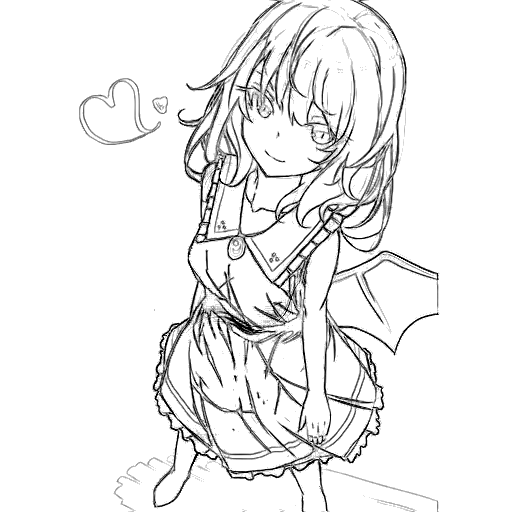

In [28]:
from PIL import Image
import numpy as np

temp = Image.open('data/train/2028006.png')
# Convert the image to a NumPy array
temp_np = np.array(temp)
# Now you can perform slicing on the NumPy array
temp_sliced = temp_np[:,512:,:]

# If you want to work with the sliced data as an image again, convert it back to a PIL Image:
temp_sliced_img = Image.fromarray(temp_sliced)
temp_sliced_img

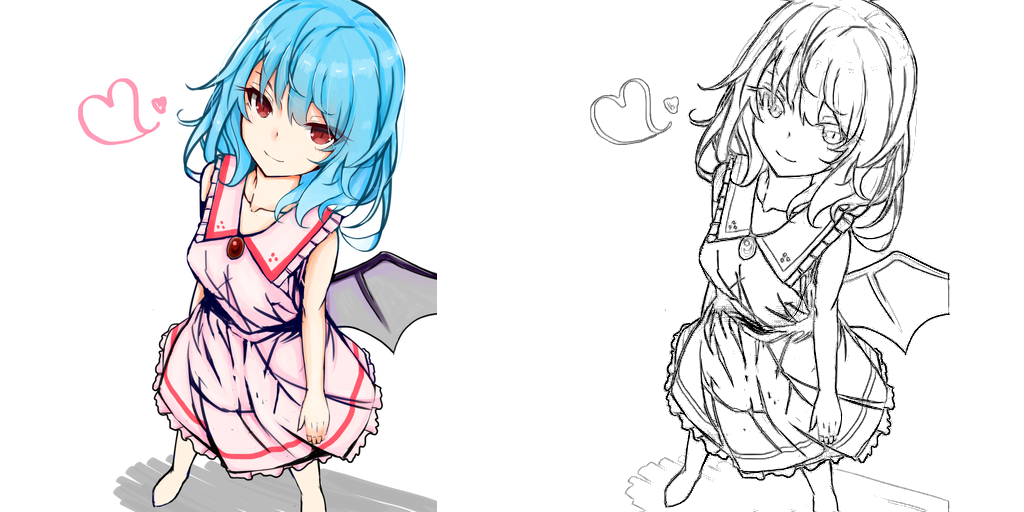

In [29]:
temp

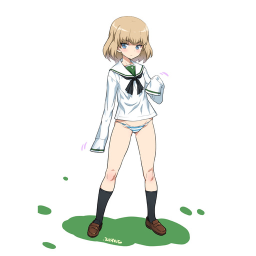

In [58]:
Image.open('evaluation/label_1.png')

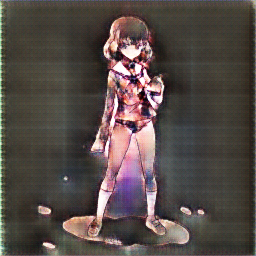

In [59]:
Image.open('evaluation/y_gen_6.png')